# A/B Testing

---

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats, special

import pymc3 as pm
from ipywidgets import interact

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

---
#### Load / Generate Time Series

In [ ]:
N = 365 # days

In [ ]:
A = np.random.lognormal(mean=0.0, sigma=1.1, size=N)
B = np.random.lognormal(mean=0.3, sigma=0.8, size=N)

In [ ]:
pd.DataFrame({'A':A,'B':B}).to_csv('data.csv', index=False)

In [ ]:
A, B = pd.read_csv('data.csv').values.T

In [ ]:
X = np.arange(1000)+1 # x range

In [ ]:
# ALL the visitors
# Visitors randomly assigned to 
allA = (3+np.random.beta(a=5, b=20, size=N))*A + 30

allB = (3+np.random.beta(a=5, b=20, size=N))*B + 30

In [ ]:
# Mean on a 7-day rolling basis
w = 4
allA, allB = pd.DataFrame({'allA': allA, 'allB': allB}).rolling(w).mean().values.T
allA[:(w-1)], allB[:(w-1)] = allA[(w-1):2*(w-1)], allB[(w-1):2*(w-1)]

---

In [ ]:
# Plot the A & B time series
trace_A = go.Scatter(x=X, y=A, name = "A", opacity = 0.8)
trace_allA = go.Scatter(x=X, y=allA, name = "allA", opacity = 0.8, line = dict(color = '#64b1fe'))

trace_B = go.Scatter(x=X, y=B, name = "B", opacity = 0.8)
trace_allB = go.Scatter(x=X, y=allB, name = "allB", opacity = 0.8, line = dict(color = '#36fe8e'))

data = [trace_A,trace_allA, trace_B, trace_allB]

layout = dict(
    title = "Split Test",
)

fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

`Question:` Which segment performs better?

---

---

## `1.` Chi-Squared Test / z-test for independent proportions

see:

[1] [A/B testing and Pearson's chi-squared test of independence](http://thestatsgeek.com/2013/07/22/ab-testing/) $\checkmark$

[2] [A/B testing - confidence interval for the difference in proportions using R](http://thestatsgeek.com/2014/02/15/ab-testing-confidence-interval-for-the-difference-in-proportions-using-r/) $\checkmark$

[3] [z-test for independent proportions](http://influentialpoints.com/Training/z-test_for_independent_proportions-principles-properties-assumptions.htm) $\checkmark$

[3] [The Binomial, Chi-squared and Fisher’s Exact tests](http://davidquigley.com/talks/2015/biostatistics/module_07.1.html)

[4] [Tests for Two 
Proportions](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Tests_for_Two_Proportions.pdf)

[5] [Exact two sample proportions binomial test in R (and some strange p-values)](https://stats.stackexchange.com/questions/123609/exact-two-sample-proportions-binomial-test-in-r-and-some-strange-p-values)

---
**Assumptions:**

- Sampling or allocation is random
- We have a sufficiently large sample
- Observations are independent
- Mutual exclusivity (A given case may fall only in one class)
- Errors are normally distributed <br/>
(Provided that the cell frequencies are reasonably large ($n$ is large and/or $p$ is close to ½), cell values in a 2 × 2 contingency table will be distributed normally about their expected values. 
If any expected frequency is less than 5, or of if pqn is less than 5, then providing you want a conventional P-value, the continuity correction should be applied.)


Cons:
- These tests don't really care about the trend by the date (i.e. does not care about spikes, trends, seasonality.. only looks at aggregate results)
- Assume sufficiently large samples

<br/>

**IDEA**

Let's suppose that we have obtained data from $n$ visitors, $n_A$ of which have been (randomly) sent to page A, and $n_B$ of which have been sent to page B.
Let $\pi_A$, $\pi_B$ denote the true success proportions for each of the segment (i.e. conversion rates). 
<br/>

---
$Null\; hypothesis:$

$$\pi_A = \pi_B$$

Is there evidence against the null?

---

*Hypothesis Test*:

We may estimate these proportions by $\hat{\pi}_A$ and $\hat{\pi}_B$.

1. Compute a test statistic: some function of the data (measures the disparity between the proportions) <br/><br/>

2. Derive the distribution of this test statistic (in repeated sampling) under the null hypothesis. <br/> It's precise distribution depends on the sampling model. <br/><br/>

3. Compute the p-value:

The *p-value* indicates the probability (under the null) that the test statistic takes a value equal to, or more extreme than the value observed. <br/>
Or, in different words: if A & B had the same conversion rate, *p-value* would tell us the chances of obtaining a test statistic, in absolute terms, at least as small as the one we've computed.

---
### `1.1` z-test for independent proportions


The standard test uses the common pooled proportion to estimate the variance of the difference between two proportions. It is identical to the chi square test, except that we estimate the standard normal deviate (z). The square of the test statistic (z2) is identical to the Pearson's chi square statistic X2.

1. Test statistic:

$$z = \frac{\hat{\pi}_A-\hat{\pi}_B}{SE}$$

Where $\hat{\pi}_A-\hat{\pi}_B$ is a point estimate of $\pi_A-\pi_B$ and SE denotes the estimated standard error of the difference in proportions (under the null):

* *Pooled*:

$$SE^2 =  Var \: (\hat{\pi}_A-\hat{\pi}_B) = Var \: (\hat{\pi}_A) + Var \: (\hat{\pi}_B) = \pi (1-\pi)/n_A + \pi (1-\pi)/n_B = \pi (1-\pi) \left(\frac{1}{n_A} +  \frac{1}{n_B}\right)$$

with $\pi$ being the success proportion over the both segments.

* *Unpooled*:

$$SE^2 =  Var \: (\hat{\pi}_A-\hat{\pi}_B) = Var \: (\hat{\pi}_A) + Var \: (\hat{\pi}_B) = \frac{\pi_A (1-\pi_A)}{n_A} + \frac{\pi_B (1-\pi_B)}{n_B}$$

In [ ]:
# successes    # size of the group
X_A = sum(A);  n_A = sum(allA)   # group A
X_B = sum(B);  n_B = sum(allB)   # group B

In [ ]:
# Success proportions
a = X_A / n_A
b = X_B / n_B

In [ ]:
# Pi
p = (X_A + X_B) / (n_A + n_B)

In [ ]:
# Standard Error 
SE_p = np.sqrt(p*(1-p)*(1/n_A+1/n_B))   # Pooled
SE_u = np.sqrt(a*(1-a)/n_A+b*(1-b)/n_B) # Unpooled

Because different estimates of the variance are used, it is possible that the results of the test may not be consistent with the confidence interval. In other words, the confidence interval of the difference may overlap zero (indicating no significant difference), yet the test indicates a significant difference.

In [ ]:
# Test Statistic
z = abs(a-b) / SE_p
print(z, '\tvs.\t', abs(a-b) / SE_u)

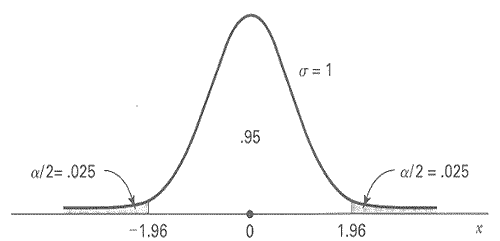

In [ ]:
z_alpha = stats.norm.ppf(0.975)
z_alpha

In [ ]:
# Probability in the tails up to the value of +/-z
pvalue = 2*stats.norm.cdf(-z) # symmetry
pvalue

In [ ]:
if pvalue > 0.05:
    print('We do not have strong evidence against the null here.')
    SE = SE_p
else:
    print('We do have evidence against the null hypothesis!')
    SE = SE_u

---
#### Confidence Intervals

One may also be interested in the confidence interval for $\pi_A-\pi_B$. 

The confidence interval gives us a range of values for the difference in proportions which are consistent with the data we have observed.

---

If the null hypothesis has been rejected, then we can no longer use the estimate of the standard error of the difference based on the combined samples. Instead the standard error of the difference is obtained by taking the square root of the sum of the individual variances.

---
`Confidence interval based on the normal distribution`

! the normal approximation interval for the difference between proportions performs poorly

In [ ]:
print('Difference in proportions:',a-b,'\nCI: (', a-b - z_alpha*SE,',', 
                                                  a-b + z_alpha*SE,')')

---
##### Correction for continuity

The sampling distribution of the estimator is discrete - the binomial distribution, while we are using a continuous distribution to represent the discrete distribution of sample frequencies - the normal distribution.

For small sample sizes, many statisticians feel that a correction for continuity should be applied.

The Yates correction to either formula is achieved by subtracting $\frac{1}{2}\left(\frac{1}{n_A} + \frac{1}{n_B}\right)$ from the modulus of the difference between the proportions.

---

[1] [Continuity Correction Factor: What is it?](http://www.statisticshowto.com/what-is-the-continuity-correction-factor/)

---
`Continuity corrected interval for the difference of proportions`

In [ ]:
# Correction term
Yates = (1/n_A+1/n_B)/2

In [ ]:
z_corr = (abs(a-b) - Yates) / SE_p
z_corr

In [ ]:
z_corr**2 # should be the same as the Chi-square statistic

In [ ]:
# Probability in the tails up to the value of +/-z
pvalue = 2*stats.norm.cdf(-z_corr)
pvalue

In [ ]:
if pvalue > 0.05:
    print('We do not have strong evidence against the null here.')
    SE = SE_p
else:
    print('We do have evidence against the null hypothesis!')
    SE = SE_u

In [ ]:
# Confidence interval:
print('CI: (', a-b - z_alpha*SE - Yates,',', 
               a-b + z_alpha*SE + Yates,')')

---
There are numerous suggestions for improved intervals.

Disagreement on which is best is so widespread that it is difficult to know which one to recommend

---
`Newcombe Hybrid Score` (superior, more robust:  [coverage probability](https://en.wikipedia.org/wiki/Coverage_probability) is closer to the nominal value) - based on the Wilson score confidence interval for a single proportion

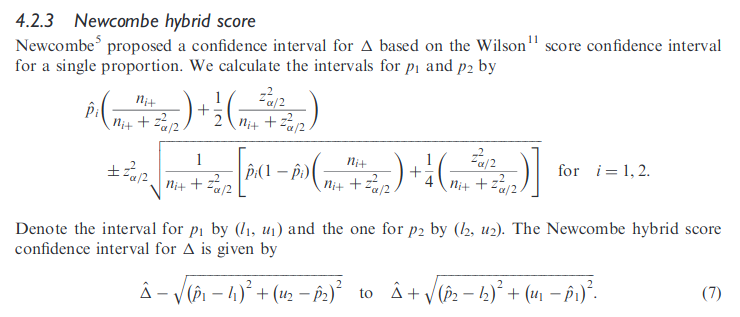

In [ ]:
l1 = a*n_A/(n_A+z_alpha**2) + 0.5*z_alpha**2/(n_A+z_alpha**2)\
        - z_alpha * np.sqrt(1/(n_A+z_alpha**2)*(a*(1-a)*n_A/(n_A+z_alpha**2) + 0.25*z_alpha**2/(n_A+z_alpha**2)))
u1 = l1 + 2*z_alpha * np.sqrt(1/(n_A+z_alpha**2)*(a*(1-a)*n_A/(n_A+z**2) + 0.25*z_alpha**2/(n_A+z_alpha**2)))

In [ ]:
l2 = b*n_B/(n_B+z_alpha**2) + 0.5*z_alpha**2/(n_B+z_alpha**2)\
        - z_alpha * np.sqrt(1/(n_B+z_alpha**2)*(b*(1-b)*n_B/(n_B+z_alpha**2) + 0.25*z_alpha**2/(n_B+z_alpha**2)))
u2 = l2 + 2*z_alpha * np.sqrt(1/(n_B+z_alpha**2)*(b*(1-b)*n_B/(n_B+z_alpha**2) + 0.25*z**2/(n_B+z_alpha**2)))

In [ ]:
# Confidence interval:
print('CI: (', a-b - np.sqrt((a-l1)**2 + (u2-b)**2),',', 
               a-b + np.sqrt((b-l2)**2 + (u1-a)**2),')')

---
`Agresti-Caffo`

In [ ]:
print('CI: (',a-b - z_alpha*np.sqrt(X_A*(n_A-X_A)/n_A**3 + X_B*(n_B-X_B)/n_B**3),
              a-b + z_alpha*np.sqrt(X_A*(n_A-X_A)/n_A**3 + X_B*(n_B-X_B)/n_B**3),')')

---
`Agresti–Min`

[1] [Recommended confidence intervals for two independent binomial proportions](http://www.ms.uky.edu/~mai/sta635/FagerlandLydersenLaake2011---RecommendedCIsForTwoIndependent....pdf)

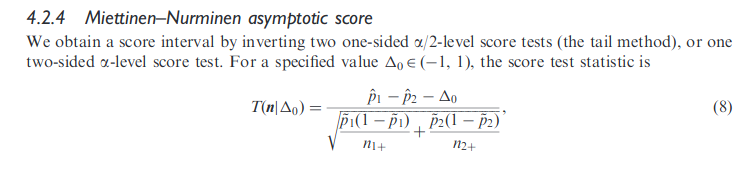


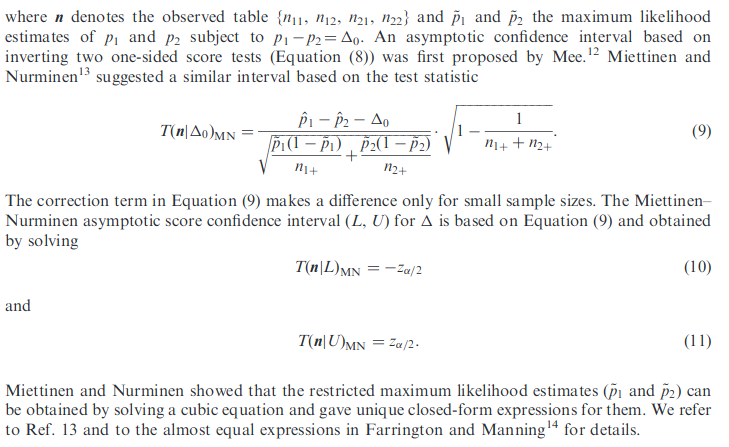

---

https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&cad=rja&uact=8&ved=0ahUKEwjDqav2-YTcAhXNIlAKHfWsDsoQwqsBCF0wCQ&url=https%3A%2F%2Fwww.khanacademy.org%2Fmath%2Fstatistics-probability%2Fsignificance-tests-one-sample%2Fmore-significance-testing-videos%2Fv%2Fone-tailed-and-two-tailed-tests&usg=AOvVaw1kiF1rqqQLqL60g3O5rsOA


However, this might not be conclusive.

A hypothetical result could be significant in a $1$-tailed test, but not in a $2$-tailed test, because it was far enough from the center to fall in the $5 \%$ region of the curve, but not far enough out to fall into the $2.5\%$ region.<br/>
But, it could also go the other way $-$ because the $2$-tailed test will allow you to reject the null hypothesis based on results that fall on both ends of the bell curve.

---

**One sided**

In [ ]:
# One-sided test
pvalue = stats.norm.cdf(z)
if z > 0:
    pvalue = 1 - pvalue
print('P-value:', 1-stats.norm.cdf(z))

In [ ]:
if pvalue > 0.05:
    print('We do not have strong evidence against the null here.')
else:
    print('We do have evidence against the null hypothesis!')

---
Comparison with **[`A/B Testing Significance Calculator`](https://neilpatel.com/ab-testing-calculator/)**

In [ ]:
# successes    # size of the group
X_A = 139;      n_A = 1000   # group A
X_B = 120;      n_B = 1000   # group B

In [ ]:
# Success proportions
a = X_A / n_A
b = X_B / n_B

In [ ]:
# Pi
p = (X_A + X_B) / (n_A + n_B)

In [ ]:
# Standard Error 
SE_p = np.sqrt(p*(1-p)*(1/n_A+1/n_B))   # Pooled
SE_u = np.sqrt(a*(1-a)/n_A+b*(1-b)/n_B) # Unpooled

In [ ]:
z = abs(a-b) / SE_p
z

In [ ]:
# One-sided test
pvalue = stats.norm.cdf(z)
if z > 0:
    pvalue = 1 - pvalue
print('P-value:', 1-stats.norm.cdf(z))

In [ ]:
if (a-b)/a <= 0:
    print('B performed {:.2f}% better than A.\n'.format(-(a-b)/a*100))
    print('I am {:.2f}% certain that the changes in Test "B" will improve your conversion rate.'\
          .format(stats.norm.cdf(z)*100))
else:
    print('A performed {:.2f}% better than B.\n'.format(-(b-a)/b*100,'.2f'))
    print('I am {:.2f}% certain that the changes in Test "A" will improve your conversion rate.'\
          .format(stats.norm.cdf(z)*100))

In [ ]:
if pvalue < 0.05:
    print('Your A/B test is statistically significant!')
elif pvalue > 0.1:
    print('Unfortunately, your results are not statistically significant.')
else:
    print('It is questionable whether your results are statistically significant.')

---
### `Central Limit Theorem`

[1] [Normal Approximations ](https://revisionmaths.com/advanced-level-maths-revision/statistics/normal-approximations)

[2] [Central Limit Theorem](http://mlwiki.org/index.php/Central_Limit_Theorem) $\checkmark$

[3] [Central Limit Theorem](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Probability/BS704_Probability12.html)

[4] [Central limit theorem for sum from varied distributions](https://stats.stackexchange.com/questions/8884/central-limit-theorem-for-sum-from-varied-distributions)

The central limit theorem states that if you have a population with mean $\mu$ and standard deviation $\sigma$ and take sufficiently large random samples from the population with replacement, then the distribution of the sample means will be approximately normally distributed.


According to the Central Limit Theorem, the sample mean of a distribution becomes approximately normal if the sample size is “large enough.” for example, the binomial distribution can be approximated with a normal distribution as long as $n\times p$ and $n\times (1-p)$ are both at least $5$.

$$\hat{\pi}_A=\frac{X_A}{n_A} \;\; \stackrel{H_0}{\sim} \;\; \mathcal{N}\left(\pi,\frac{\pi(1-\pi)}{n_A}\right)$$

In [ ]:
%%time
# simulate data to show CLT in action
n=3000

A = np.random.lognormal(mean=0.0, sigma=1.1, size=(N,n))
B = np.random.lognormal(mean=0.3, sigma=0.8, size=(N,n))

allA = (3+np.random.beta(a=5, b=20, size=(N,n)))*A + 30
allB = (3+np.random.beta(a=5, b=20, size=(N,n)))*B + 30
allA = pd.DataFrame(allA).rolling(w).mean().values
allB = pd.DataFrame(allB).rolling(w).mean().values
allA[:(w-1)], allB[:(w-1)] = allA[(w-1):2*(w-1)], allB[(w-1):2*(w-1)]

piA = np.sum(A, axis=0) / np.sum(allA, axis=0)
piB = np.sum(B, axis=0) / np.sum(allB, axis=0)

In [ ]:
r = max(piA)
xrange = np.arange(min(piA),max(piA),0.0005)
histA = go.Histogram(x=piA, 
                    opacity=0.75, 
                    histnorm='probability density',
#                     xbins=dict(
#                         start=-1,
#                         end=1,
#                         size=0.01),
                     name='A',
                    showlegend=False
                    )
histB = go.Histogram(x=piB, 
                    opacity=0.75, 
                    histnorm='probability density',
                     name='B',
                     visible=False,
#                     xbins=dict(
#                         start=-1,
#                         end=1,
#                         size=0.01),
                    showlegend=False
                    )
pdfA = go.Scatter(x=xrange, 
                 y=stats.norm(loc=np.mean(piA), scale=np.std(piA)).pdf(xrange),
                 mode='lines',                      # 0.987581
                 line=dict(width=1.5, 
                           shape='spline'),
                 name='Normal',
                 visible=False,
                 showlegend=False
                 )
pdfB = go.Scatter(x=xrange, 
                  y=stats.norm(loc=np.mean(piB), scale=np.std(piB)).pdf(xrange),
                  mode='lines',                      # 0.987581
                  line=dict(width=1.5, 
                            shape='spline'),
                  name='Normal',
                  visible=False,
                  showlegend=False
                 )
data = [histA, pdfA, histB, pdfB]

updatemenus = list([
    dict(type="buttons",
         active=-1,
         buttons=list([
            dict(label = 'Histogram A',
                 method = 'update',
                 args = [{'visible': [True, False, False, False]}]),
            dict(label = 'PDF A',
                 method = 'update',
                 args = [{'visible': [True, True, False, False]}]),
            dict(label = 'Histogram B',
                 method = 'update',
                 args = [{'visible': [True, True, True, False]}]),
            dict(label = 'PDF B',
                 method = 'update',
                 args = [{'visible': [True, True, True, True]}])
        ]),
    )
])

layout = dict(showlegend=False, #title='CLT',
              barmode='overlay',
              xaxis = dict(range = [min(min(piA),min(piB)),r]),
              yaxis = dict(range = [0,200]),
              updatemenus=updatemenus)

fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

If we were to repeat the experiment again and again. We would get the above histograms.

In [ ]:
histA = go.Histogram(x=np.array(piA)-np.array(piB), 
                    opacity=0.75, 
                    histnorm='probability density',
#                     xbins=dict(
#                         start=-1,
#                         end=1,
#                         size=0.01),
                     name='A',
                     showlegend=False,
#                      visible=False
                    )
iplot([histA], show_link=False)

In [ ]:
RV = np.random.normal(size=1000)
r = max(max(RV),-min(RV))
xrange = np.arange(-1.2*r,1.2*r,0.0025)
hist = go.Histogram(x=RV, 
                    opacity=0.75, 
                    histnorm='probability density',
                    showlegend=False
                    )

pdf = go.Scatter(x=xrange, 
                 y=stats.norm(loc=np.mean(RV), scale=np.std(RV)).pdf(xrange),
                 mode='lines',              
                 line=dict(width=1.5, 
                           shape='spline'),
                 visible=False,
                 showlegend=False
                 )
                 
data = [hist, pdf]

updatemenus = list([
    dict(type="buttons",
         active=-1,
         buttons=list([
            dict(label = 'Histogram',
                 method = 'update',
                 args = [{'visible': [True, False]}]),
            dict(label = 'Normal PDF',
                 method = 'update',
                 args = [{'visible': [True, True]}]),
        ]),
    )
])

layout = dict(showlegend=False,
              xaxis = dict(range = [-r,r]),
              updatemenus=updatemenus)

fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

In [ ]:
P = A/allA-B/allB
r = max(max(P),-min(P))
xrange = np.arange(-r,r,0.0025)
hist = go.Histogram(x=P, 
                    opacity=0.75, 
                    histnorm='probability density',
                    xbins=dict(
                        start=-1,
                        end=1,
                        size=0.01),
                    showlegend=False
                    )
pdf = go.Scatter(x=xrange, 
                 y=stats.norm(loc=np.mean(P), scale=np.std(P[(P <= 2.5*np.std(P)) & (P > -2.5*np.std(P))])).pdf(xrange),
                 mode='lines',                      # 0.987581
                 line=dict(width=1.5),
                 name='Normal',
                 visible=False,
                 showlegend=False
                 )
data = [hist, pdf]

updatemenus = list([
    dict(type="buttons",
         active=-1,
         buttons=list([
            dict(label = 'Histogram',
                 method = 'update',
                 args = [{'visible': [True, False]}]),
            dict(label = 'Normal PDF',
                 method = 'update',
                 args = [{'visible': [True, True]}]),
        ]),
    )
])

layout = dict(showlegend=False, #title='CLT',
              xaxis = dict(range = [-r,r]),
              updatemenus=updatemenus)

fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

In [ ]:
new_A, new_allA = pd.DataFrame({'A': A, 'allA': allA}).rolling(10).sum().values.T

In [ ]:
data = [go.Histogram(x=new_A / new_allA, 
                     opacity=0.75,
                    xbins=dict(
                        start=0,
                        end=1,
                        size=0.003)
                    )]
iplot(data, show_link=False)

---

In [ ]:
data = new_A/new_allA
data = data[~np.isnan(data)]

In [ ]:
qq = stats.probplot(data, dist='lognorm', sparams=(1))
x = np.array([qq[0][0][0],qq[0][0][-1]])
pts = go.Scatter(x=qq[0][0],
                 y=qq[0][1], 
                 mode = 'markers',
                 showlegend=False
                )
line = go.Scatter(x=x,
                  y=qq[1][1] + qq[1][0]*x,
                  showlegend=False,
                  mode='lines'
                 )

data = [pts, line]
layout = dict(xaxis = dict(zeroline = False,
                           linewidth = 1,
                           mirror = True),
              yaxis = dict(zeroline = False, 
                           linewidth = 1,
                           mirror = True),
             )

fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

---
The z-test is essentially identical to the chi square test, except that we estimate the standard normal deviate ($z$).<br/>
The square of the test statistic ($z^2$) is identical to the Pearson's chi square statistic $\chi^2$<br/><br/>
The z-test is sometimes preferred to the chi-square test as it allows the computation of the size of the difference between the two proportions. A confidence interval can be attached to that difference using either the normal approximation or a variety of exact or small sample methods.

[Binomial confidence intervals and contingency tests: mathematical fundamentals and the evaluation of alternative meth
ods](https://www.ucl.ac.uk/english-usage/staff/sean/resources/binomialpoisson.pdf)

---
### `1.2` Chi-squared Test  

[1] [Pearson's chi-squared test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)

[2] [Pearson's chi square test of independence](http://influentialpoints.com/Training/pearsons_chi_square_test_of_independence-principles-properties-assumptions.htm#assu)

Pearson's chi-squared test ($\chi^2$) is a statistical test applied to sets of categorical data to evaluate how likely it is that any observed difference between the sets arose by chance.

It is suitable for unpaired data from large samples.

It tests a null hypothesis stating that the frequency distribution of certain events observed in a sample is consistent with a particular theoretical distribution. The events considered must be mutually exclusive and have total probability 1.

---

1. Calculate the chi-squared test statistic, $\chi^{2}$, which resembles a normalized sum of squared deviations between observed and theoretical frequencies.<br/><br/>

2. Determine the degrees of freedom, $df$, of that statistic. <br/>
For test of independence, $df = (Rows - 1)×(Cols - 1)$, where in this case, Rows corresponds to number of categories in one variable, and Cols corresponds to number of categories in the second variable. Thus for a two by two contingency table there is always just one degree of freedom. <br/><br/>

3. Accept or reject the null hypothesis based on a desired level of confidence (significance level)

In [ ]:
CT = [[X_A, n_A-X_A], [X_B, n_B-X_B]]
CT

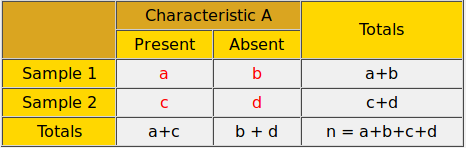

$$\chi^2 = \frac{n\left(ad-bc\right)^2}{\left(a+b\right)\left(a+c\right)\left(b+d\right)\left(c+d\right)}$$

In [ ]:
n = sum(cell for row in CT for cell in row)

In [ ]:
# Chi-square score
chi2 = (n-1)*(CT[0][0]*CT[1][1]-CT[0][1]*CT[1][0])**2/\
        ((CT[0][0]+CT[0][1])*(CT[0][0]+CT[1][0])*(CT[0][1]+CT[1][1])*(CT[1][0]+CT[1][1]))
chi2

For the 2 × 2 table the formulation above is mathematically identical to the square of the statistic obtained in the z-test for independent proportions.

In [ ]:
# Same as
z**2

In [ ]:
# Critical value
stats.chi2(df=1).ppf(.95)

In [ ]:
# p-value
1-stats.chi2(df=1).cdf(chi2)

---

The correction is usually only recommended if the smallest expected frequency is less than 5. Note that the correction should not be applied if |ad − bc| is less than n/2.

In [ ]:
# With Yates correction
chi2_corr = n*(abs(CT[0][0]*CT[1][1]-CT[0][1]*CT[1][0]) - n/2)**2/\
            ((CT[0][0]+CT[0][1])*(CT[0][0]+CT[1][0])*(CT[0][1]+CT[1][1])*(CT[1][0]+CT[1][1]))
chi2_corr

In [ ]:
# Same as
z_corr**2

In [ ]:
# p-value
1-stats.chi2(df=1).cdf(chi2_corr)

---

In [ ]:
# Chi-square score
chi2 = (n-1)*(CT[0][0]*CT[1][1]-CT[0][1]*CT[1][0])**2/\
        ((CT[0][0]+CT[0][1])*(CT[0][0]+CT[1][0])*(CT[0][1]+CT[1][1])*(CT[1][0]+CT[1][1]))
chi2

---

In [ ]:
# PYTHON: PEARSON CHI-SQUARE TEST
# Does Yates' correction
# (R analogue: chisq.test(), prop.test() ~ gives also the confidence interval)

# Get statistic, p-value
stat, pvalue, *rest = stats.chi2_contingency(CT)

In [ ]:
# z**2 computed with Yates' continuity correction
stat

In [ ]:
# Look at p-value
pvalue

In [ ]:
if pvalue > 0.05:
    print('We do not have strong evidence against the null here.')
else:
    print('We do have evidence against the null hypothesis!')

This shows the rate that this difference between A and B can happen by a random chance. In this case, the number is `x`, which means that this difference can happen by chance at a rate of `x*100%`. <br/>
And this means, in a world where this value needs to be less than 5% to state a statistical significance, we can/can’t conclude that the difference between A and B is statistically significant. 

The probability that we would observe this or an even more imbalanced ratio by chance is about 3.5%.<br/>
A commonly used significance level is 5%–if we adopt that, we can therefore conclude that our observed imbalance is statistically significant

---
#### Confidence Interval

For small sample sizes, many - but not all - statisticians feel that a correction for continuity should be applied. This is because a continuous distribution (chi square) is being used to represent the discrete distribution of sample frequencies. 

In [ ]:
# alternative = "two.sided"
conf_level = 0.95

In [ ]:
ESTIMATE = np.array([a, b])
n = np.array([n_A, n_B])

In [ ]:
WIDTH = stats.norm.ppf((1 + conf_level)/2) * np.sqrt(sum(ESTIMATE * (1 - ESTIMATE)/n)) + Yates

In [ ]:
print('CI: (',max(a-b - WIDTH, -1),',', min(a-b + WIDTH, 1),')')

! The approximation to the chi-squared distribution breaks down if expected frequencies are too low

---

For very small sample sizes the conventional wisdom has been to use Fisher's exact test, although use of an exact test based on the correct model is now preferred. 

http://influentialpoints.com/Training/pearsons_chi_square_test_of_independence-principles-properties-assumptions.htm#exac

---

### Fisher's exact test

[1] [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test#cite_note-Choi2015-19)

[1] [Two-Sample Binomial Proportion Test](http://mlwiki.org/index.php/Binomial_Proportion_Tests#Two-Sample_Binomial_Proportion_Test)

[2] https://stats.stackexchange.com/questions/16319/one-sided-fishers-exact-test-and-its-complement

https://en.wikipedia.org/wiki/Fisher%27s_exact_test#cite_note-Choi2015-19

---
Although in practice it is employed when sample sizes are small, it is valid for all sample sizes.

When one or more of the counts in the $2\times2$ table are small (i.e. $<5$) the asymptotic justification of Pearson's chi-squared test may not be appropriate. One alternative is Fisher's so called 'exact' test. 

Calculates the probability of observing the observed data or more extreme, under the null hypothesis.

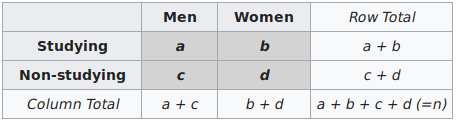

In [ ]:
[a, b], [c, d] = CT
n = a + b + c + d

![Image](https://wikimedia.org/api/rest_v1/media/math/render/svg/355286b9e9fdc48395ff99ab24694092ee8f5b49)

Hypergeometric Distribution

In [ ]:
# stats.hypergeom.pmf(b, n, a+b, b+d, loc=0)

In [ ]:
# One-sided LESS
pvalue = 0.0
for i in range(a+1):
    pvalue += stats.hypergeom.pmf((b+i), n, a+b, b+d)
pvalue

In [ ]:
# One-sided GREATER
pvalue = 0.0
for i in range(b+1):
    pvalue += stats.hypergeom.pmf(b-i, n, a+b, b+d)
pvalue

In [ ]:
# Need to do some binary search here, use function

---

In [ ]:
oddsratio, pvalue = stats.fisher_exact([[1, 9], [11, 4]], 'less')
pvalue

---

In [ ]:
oddsratio, pvalue = stats.fisher_exact(CT)
pvalue

In [ ]:
# H0: A==B 
# H1: Number of conversions is lower in group A
oddsratio, pvalue = stats.fisher_exact([[a, b], [c, d]], alternative='less')
pvalue

---
Fisher's test or Chi-square?

This is actually something that is debated among statisticians. Historically, you avoided Fisher's because it becomes very computationally complex. Generally speaking, however, Fisher's Exact Test is conservative and if your numbers are large enough, the chi-square statistic (which is what prop.test calculates) is more likely to not commit a type II error.

---

---

---

## Bayesian A/B Testing

[1] [Introduction to bayesAB](https://cran.r-project.org/web/packages/bayesAB/vignettes/introduction.html)

[2] [Package ‘bayesAB’](https://cran.r-project.org/web/packages/bayesAB/bayesAB.pdf)

[2] [Coding Bayesian AB Tests in Python to Boost your App or Website Conversions](https://medium.com/@thibalbo/coding-bayesian-ab-tests-in-python-e89356b3f4bd)

[3] [Stastical Advice for A/B Testing](http://sl8r000.github.io/ab_testing_statistics/#)

[4] [A/B Testing with Hierarchical Models in Python](https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/)

[5] [Formulas for Bayesian A/B Testing](https://www.evanmiller.org/bayesian-ab-testing.html)

[6] []()

---

---
### [An Introduction to Bayesian A/B Testing in Exploratory](https://blog.exploratory.io/an-introduction-to-bayesian-a-b-testing-in-exploratory-cb5a7ad80963)

- Give you ‘probability’ of how much A is better (or worse) than B <br/>


\+ More intuitive

\+ You don’t have to worry too much about the test size when you evaluate the result (you can start evaluating the result from the first day)


$Prior$

$Posterior$

In [ ]:
# Expected Improvement Rate ~ how much A is better than B. 
# (A-B) / B * 100

In [ ]:
df = pd.DataFrame({'landingPage': ['A','B']*5,           
                   'uniquePageView': [600,199,1129,1127,1008,1145,1107,1108,959,970],
                   'signUpCount': [65,22,104,111,101,129,119,110,85,90]})
df['ConversionRate'] = df['signUpCount']/df['uniquePageView']
df

In [ ]:
A = np.array(df.loc[df['landingPage']=='A','ConversionRate'])
B = np.array(df.loc[df['landingPage']=='B','ConversionRate'])

---

In [ ]:
# Simulate some data
n = 100

# Visitors
A, B = np.random.binomial(2000, p=0.5, size=(2, n))

# Add conversions
A = np.column_stack([A, np.random.binomial(n=A, p=0.05)])
B = np.column_stack([B, np.random.binomial(n=B, p=0.06)])

# Conversion Rates
a = A[:,1] / A[:,0]
b = B[:,1] / B[:,0]

In [ ]:
dt = (a-b)/a
hist1 = go.Histogram(x=dt[dt>=0], 
                    opacity=0.75, 
                    xbins=dict(
                        start=0,
                        end=1,
                        size=0.04),
                    histnorm='',
                    name='A is Better',
                    showlegend=False,
                    )
hist2 = go.Histogram(x=dt[dt<0], 
                    opacity=0.75, 
                    xbins=dict(
                        start=-1,
                        end=0,
                        size=0.04),
                    histnorm='',
                    name='A is not better',
                    showlegend=False,
                    )
layout = go.Layout(barmode='overlay', 
                  title='Relative difference: (A-B)/A',
                  yaxis=dict(title='Counts'))
fig = go.Figure(data=[hist1, hist2], layout=layout)
iplot(fig, show_link=False)

In [ ]:
# The probability of A being ~ up to 2% better than B (take the median of the interval)
sum((dt>=0.0) & (dt<0.04))/len(dt)

In [ ]:
# The probability of A being ~ 8-10% worse than B (take the median of the interval)
sum((dt>=-0.12) & (dt<-0.08))/len(dt)

---

In [ ]:
# Probability of A being better
(dt>0).mean()

In [ ]:
# Probability of B being better
(dt<0).mean()

In [ ]:
# Expected Improvement Rate if segment B is chosen (assume that A is the current setup)
b.mean()- a.mean()

---
#### Add Prior information to the model

In [ ]:
# Real-time performance
# updating priors

---

In [ ]:
a = np.random.normal(1200, 100, 1000)
b = np.random.normal(1500, 150, 1000)
df = pd.DataFrame(np.transpose([a,b]), columns=['a','b'])
a = df.a
b = df.b

trace1 = go.Histogram(
    x=df.a,
    opacity=0.75,
    histnorm='probability',
    name='> 180 t/h'
)
trace2 = go.Histogram(
    x=df.b,
    opacity=0.75,
    histnorm='probability',
    name='< 160 t/h',
    yaxis='y2'
)

# Create traces


data = [trace1, trace2]

layout = go.Layout(
    title='item',
    barmode='overlay',
    xaxis=dict(
    title=''
    ),
    yaxis=dict(
        title='Normalized Frequency < 160 t/h'
    ),
    yaxis2=dict(
        title='Normalized Frequency > 180 t/h',
        anchor='free',
        overlaying='y',
        side='right',
        position=1
    ),

    # Mean lines
    shapes= [{'line': {'color': '#0099FF', 'dash': 'solid', 'width': 1},
    'type': 'line',
    'x0': df.a.mean(),
    'x1': df.a.mean(),
    'xref': 'x',
    'y0': -0.1,
    'y1': 1,
    'yref': 'paper'},
   {'line': {'color': '#FDAB5A', 'dash': 'solid', 'width': 1},
    'type': 'line',
    'x0': df.b.mean(),
    'x1': df.b.mean(),
    'xref': 'x',
    'y0': -0.1,
    'y1': 1,
    'yref': 'paper'}],

    # Annotations
    annotations=[
        dict(
            x=df.a.mean(),
            y=1,
            xref='x',
            yref='paper',
            text="Mean a = {:,.0f}".format(df.a.mean()),
            showarrow=True,
            arrowhead=7,
            ax=1,
            ay=1,
            axref='paper',
            ayref='paper'
        ),
        dict(
            x=df.b.mean(),
            y=0.95,
            xref='x',
            yref='paper',
            text="Mean b = {:,.0f}".format(df.b.mean()),
            showarrow=True,
            arrowhead=7,
            ax=1,
            ay=1,
            axref='paper',
            ayref='paper'
        )
    ]

) 
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

---

### [Bayesian A/B Testing with Python](https://medium.com/hockey-stick/tl-dr-bayesian-a-b-testing-with-python-c495d375db4d)

The broad idea behind Bayesian conversion rate testing is to generate two distributions which cover all possible rates and then update them with information about the test performance and adjust our expectation of the most representative rate accordingly.

In [ ]:
xrange = np.arange(0,0.5,0.0025)
beta1 = go.Scatter(x=xrange, 
                  y=stats.beta.pdf(xrange, a=16, b=100-16), 
                  mode='lines',
                  line=dict(width=1.5),
                  name='Beta(16, 84)',
                 )
beta2 = go.Scatter(x=xrange, 
                     y=stats.beta.pdf(xrange, a=8, b=42),  
                     mode='lines',
                     line=dict(width=1.5),
                     name='Beta(8, 42)',
                    )
                    
data = [beta1, beta2]
iplot(data, show_link=False)

---
#### Generating a small number of random results

In [ ]:
people_in_branch = 50

# Control is Alpaca, Experiment is Bear
control, experiment = np.random.rand(2, people_in_branch)

c_successes = sum(control < 0.16)

# Bears are about 10% better relative to Alpacas
e_successes = sum(experiment < 0.176)

c_failures = people_in_branch - c_successes
e_failures = people_in_branch - e_successes

# Our Priors
prior_successes = 8
prior_failures = 42

---

In [ ]:
# Control
c_alpha, c_beta = c_successes + prior_successes, c_failures + prior_failures
# Experiment
e_alpha, e_beta = e_successes + prior_successes, e_failures + prior_failures

x = np.linspace(0., 0.5, 1000)

# Generate and plot the distributions!
c_distribution = stats.beta(c_alpha, c_beta)
e_distribution = stats.beta(e_alpha, e_beta)

In [ ]:
trace_C = go.Scatter(x=x,
                     y=c_distribution.pdf(x),
                     name="Control",
                     opacity=0.8,
                     line=dict(shape='spline')
                    )

trace_E = go.Scatter(x=x,
                     y=e_distribution.pdf(x),
                     name="Experiment",
                     opacity=0.8,
                     line=dict(shape='spline')
                    )

data = [trace_C, trace_E]

layout = dict(
    title = "Split Test",    
    xaxis=dict(title='Conversion Rate',),
    yaxis=dict(title='Density',)
)

fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

It’s pretty clear we need some more data to make an accurate decision

---
#### More Data

In [ ]:
more_people_in_branch = 4000

# Control is Alpaca, Experiment is Bear
control, experiment = np.random.rand(2, more_people_in_branch)

# Add to existing data
c_successes += sum(control < 0.16)
e_successes += sum(experiment < 0.176)

c_failures += more_people_in_branch - sum(control < 0.16)
e_failures += more_people_in_branch - sum(experiment < 0.176)

---

In [ ]:
# Control
c_alpha, c_beta = c_successes + prior_successes, c_failures + prior_failures
# Experiment
e_alpha, e_beta = e_successes + prior_successes, e_failures + prior_failures

# Generate and plot the distributions!
c_distribution = stats.beta(c_alpha, c_beta)
e_distribution = stats.beta(e_alpha, e_beta)

In [ ]:
trace_C = go.Scatter(
                x=x,
                y=c_distribution.pdf(x),
                name = "Control",
                opacity = 0.8,
                line = dict(shape = 'spline')
)

trace_E = go.Scatter(
                x=x,
                y=e_distribution.pdf(x),
                name = "Experiment",
                opacity = 0.8,
                line = dict(shape = 'spline')
)

data = [trace_C,trace_E]

layout = dict(
    title = "Split Test",    
    xaxis=dict(title='Conversion Rate',),
    yaxis=dict(title='Density',)
)


fig = dict(data=data, layout=layout)
# fig.xaxis.update(title = 'AA')

iplot(fig, show_link=False)

In [ ]:
# Arguments are x values so use ppf - the inverse of cdf
print(c_distribution.ppf([0.025, 0.5, 0.975]))
print(e_distribution.ppf([0.025, 0.5, 0.975]))

---
**Bayesian p-values**

What is the probability that Alpacas are actually better than Bears?

In [ ]:
sample_size = 100000

c_samples = c_distribution.rvs(size=sample_size)
e_samples = e_distribution.rvs(size=sample_size)

p_ish_value = np.mean(c_samples > e_samples)
p_ish_value

---
How much of an improvement we think the Experiment is vs. the Control?

In [ ]:
# Generate a CDF of the B samples over the A samples
ser = np.sort(e_samples/c_samples)
cum_dist = np.linspace(0., 1., len(ser))

In [ ]:
trace = go.Scatter(x=ser,
                   y=cum_dist,
                   line=dict(shape='spline'))
data = [trace]

layout = dict(
    title = "CDF of the B samples over the A samples",    
    xaxis=dict(title='Bears / Alpacas'),
    yaxis=dict(title='CDF')
)

fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

There aren’t many values below 0 meaning the A branch didn’t win very often. 

Eyeballing the median we can see it’s pretty close to 1.1, agreeing with our initial “10% better” setting.

---
---

### [Coding Bayesian AB Tests in Python](https://medium.com/@thibalbo/coding-bayesian-ab-tests-in-python-e89356b3f4bd)

You select 10% of yours users to participate in the test. From those 10%, you split into 2, 3, x variations. The 90% you never touch until you are happy with the results and then scale to all users.

---
#### Build the model

In [ ]:
# Data
n = 1000
obs_v1 = 680 # observed successes on V1
obs_v2 = 700 # observed successes on V2

Use a *Beta distribution* for the priors and a *Bernoulli distribution* for the likelihood:

In [ ]:
with pm.Model() as model: # context management
    # define priors
    prior_v1 = pm.Beta('prior_v1', alpha=2, beta=2)
    prior_v2 = pm.Beta('prior_v2', alpha=2, beta=2)

    # define likelihood
    like_v1 = pm.Binomial('like_v1', n=n, p=prior_v1, observed=obs_v1)
    like_v2 = pm.Binomial('like_v2', n=n, p=prior_v2, observed=obs_v2)
    

In [ ]:
with model:
    # define metrics
    pm.Deterministic('difference', prior_v2 - prior_v1)
    pm.Deterministic('relation', (prior_v2/prior_v1) - 1)

In [ ]:
xs = np.linspace(0,1,100)
trace = go.Scatter(x = xs, y = stats.beta(2,2).pdf(xs))
iplot([trace], show_link=False)

In [ ]:
with model:
    # inference
    trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)

In [ ]:
pm.traceplot(trace[1000:], grid=True);

In [ ]:
# Posterior: difference & relative
_ = pm.plot_posterior(trace[1000:], varnames=['difference', 'relation'], 
ref_val=0, color='#87ceeb')

---

In [ ]:
xs = np.linspace(0,1,100)
trace = go.Scatter(x = xs, y = stats.beta(20,10000).pdf(xs),
                   line = dict(shape='spline')
                  )
iplot([trace], show_link=False)

In [ ]:
n = 100
# Visitors
A, B = np.random.binomial(10000, 0.1, size=(2, n))

# Add conversions
A = np.column_stack([A, np.random.binomial(n=A, p=0.06)])
B = np.column_stack([B, np.random.binomial(n=B, p=0.05)])

????

In [ ]:
# Plot the A & B time series
xs = np.arange(1,n+1)
trace_A = go.Scatter(x=xs, y=A[:,1], name = "A", opacity = 0.8)
trace_allA = go.Scatter(x=xs, y=A[:,0], name = "allA",
                        opacity = 0.8, 
                        line = dict(color = '#64b1fe'),
                        showlegend=False)
trace_B = go.Scatter(x=xs, y=B[:,1], name = "B", opacity = 0.8)
trace_allB = go.Scatter(x=xs, y=B[:,0], name = "allB",
                        opacity = 0.8, 
                        line = dict(color = '#36fe8e'),
                        showlegend=False)

data = [trace_A, trace_allA, trace_B, trace_allB]

layout = dict(
    title = "Split Test",
)

fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

In [ ]:
A[:,0], B[:,0] = np.cumsum(-np.diff(A)[:, 0]), np.cumsum(-np.diff(B)[:, 0])
A[:,1], B[:,1] = np.cumsum(A[:,1]), np.cumsum(B[:,1])

In [ ]:
np.column_stack([A,B])

In [ ]:
# Plot evolution of the distributions


In [ ]:
xs = np.linspace(0, 1, 10000)

fig = go.FigureWidget()
dist1 = fig.add_scatter(x=xs, name='A')
dist2 = fig.add_scatter(x=xs, name='B')
fig['layout'].update(yaxis=dict(range=[0,580]),
                     xaxis=dict(range=[0,0.15])
                    )

@interact(day=(1, n, 1))
def update(day=1):
    with fig.batch_update():
        print('A:',A[day-1,1],A[day-1,0],'\tB:',B[day-1,1],B[day-1,0])
        dist1.y = stats.beta(A[day-1,1],A[day-1,0]).pdf(xs)
        dist2.y = stats.beta(B[day-1,1],B[day-1,0]).pdf(xs)
fig

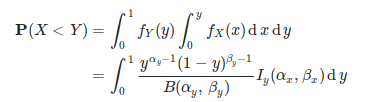

In [ ]:
array([[  889,    50,   926,    43],
       [ 1782,   111,  1891,    85],
       [ 2736,   183,  2836,   139],
       [ 3669,   231,  3784,   193],
       [ 4601,   294,  4799,   229],
       [ 5539,   348,  5767,   281],

In [ ]:
1-special.beta(3,6)/special.beta(3,1)

In [ ]:
55/56

In [ ]:
alpha1, beta1, alpha2, beta2 = 50, 889, 43, 926
rng = np.arange(1,alpha1)

In [ ]:
1 - special.beta(alpha2, beta1+beta2)/special.beta(alpha2, beta2)-\
np.sum(special.beta(alpha2+rng, beta1+beta2)/((rng+1)*special.beta(rng, beta2)*special.beta(alpha2, beta2)))

In [ ]:
special.beta(alpha2+rng, beta1+beta2)

In [ ]:
def prob_xGy(alpha1, beta1, alpha2, beta2):
    p = 1 - special.beta(alpha2, beta1+beta2)/special.beta(alpha2, beta2)
    rng = np.arange(1,alpha1)
    p -= np.sum(special.beta(alpha2+rng, beta1+beta2)/(rng+1*special.beta(rng, beta2)*special.beta(alpha2, beta2)))
    return p

In [ ]:
prob_xGy(alpha1=50, beta1=889, alpha2=43, beta2=926)

https://math.stackexchange.com/questions/897048/finding-px-y-where-x-and-y-have-two-different-beta-distributions

In [ ]:
special.betainc(1,,)

In [ ]:
A_post

In [ ]:
N = 100000
trace = [0.5]
for i in range(n):
    # simulate draws from the posteriors    
    A_post = stats.beta(A[i,1], A[i,0]).rvs(size=N)
    B_post = stats.beta(B[i,1], B[i,1]).rvs(size=N)
    
    # compute the P(A better than B):
    trace.append(1.0 - np.mean(A_post > B_post))

In [ ]:
xs = np.arange(n+1)
data = go.Scatter(x=xs, y=trace, name = "A", opacity = 0.8)

data = [data]

layout = dict(
    title = "Real-time evolution",
    yaxis = dict(range=[0,1]),
    
    # Mean lines
    shapes= [{'line': {'color': '#333F44', 'dash': 'dash', 'width': 1},
    'type': 'line',
    'x0': 0,
    'x1': n,
    'xref': 'x',
    'y0': 0.025,
    'y1': 0.025,
    'yref': 'paper'},
   {'line': {'color': '#333F44', 'dash': 'dash', 'width': 1},
    'type': 'line',
    'x0': 0,
    'x1': n,
    'xref': 'x',
    'y0': 0.975,
    'y1': 0.975,
    'yref': 'paper'}],
)

fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

---
---
### [A/B Testing with Hierarchical Models in Python](https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/)

using Beta-Binomial Hierarchical models

~ used for testing multiple hypotheses

https://www.udemy.com/bayesian-machine-learning-in-python-ab-testing/